In [33]:
import pandas as pd
import numpy as np
import gpflow as gpf

In [34]:
#import data: 
dat = pd.read_csv('./GP_365_Preprocessed.csv', index_col = 'Unnamed: 0')
print(dat.shape)
dat.head()

(151609, 5)


,site,MonitorData,day,x,y
0,0,5.9,15,3.767606e+06,739558.671618
1,0,11.0,18,3.767606e+06,739558.671618
2,0,8.6,21,3.767606e+06,739558.671618
3,0,6.2,24,3.767606e+06,739558.671618
4,0,7.6,27,3.767606e+06,739558.671618


In [35]:
#just take one site for 100 days. Just use time 

dat_s0 = dat[dat.site == 0]

#X is [time]
X_dat = dat_s0.day.values.reshape(len(dat_s0), 1) 

#Y is Monitor Values
Y_dat = dat_s0.MonitorData.values.reshape(len(dat_s0), 1)

In [4]:
with gpf.defer_build():
    X = np.random.rand(20, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(20,1) * 0.01
    m = gpf.models.GPR(X, Y, kern=gpf.kernels.Matern32(1) + gpf.kernels.Linear(1))

In [6]:
# #Make simpe GP model
# with gpf.defer_build():
#     X = X_dat
#     Y = Y_dat
#     m = gpf.models.GPR(X, Y, kern=gpf.kernels.RBF(1))

In [6]:
m.kern.matern32.variance.prior = gpf.priors.Gamma(2,3)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/matern32/variance,Parameter,"Ga([ 2.],[ 3.])",+ve,True,(),True,1.0
GPR/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/linear/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [7]:
# #Set gamma prior on RBF kernel params: 
# m.kern.variance.prior = gpf.priors.Gamma(2,3)
# m.kern.lengthscales.prior = gpf.priors.Gamma(2,3)
# m.as_pandas_table()

In [8]:
#Train params 
m.compile()

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [10]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.152121
  Number of iterations: 39
  Number of functions evaluations: 49


In [11]:
#Another exmample: 

In [13]:
import tensorflow as tf

class LinearMulticlass(gpf.models.Model):
    def __init__(self, X, Y, name=None):
        super().__init__(name=name) # always call the parent constructor

        self.X = X.copy() # X is a numpy array of inputs
        self.Y = Y.copy() # Y is a 1-of-k representation of the labels

        self.num_data, self.input_dim = X.shape
        _, self.num_classes = Y.shape

        #make some parameters
        self.W = gpf.Param(np.random.randn(self.input_dim, self.num_classes))
        self.b = gpf.Param(np.random.randn(self.num_classes))

        # ^^ You must make the parameters attributes of the class for
        # them to be picked up by the model. i.e. this won't work:
        #
        # W = gpflow.Param(...    <-- must be self.W

    @gpf.params_as_tensors
    def _build_likelihood(self): # takes no arguments
        p = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b) # Param variables are used as tensorflow arrays.
        return tf.reduce_sum(tf.log(p) * self.Y) # be sure to return a scalar

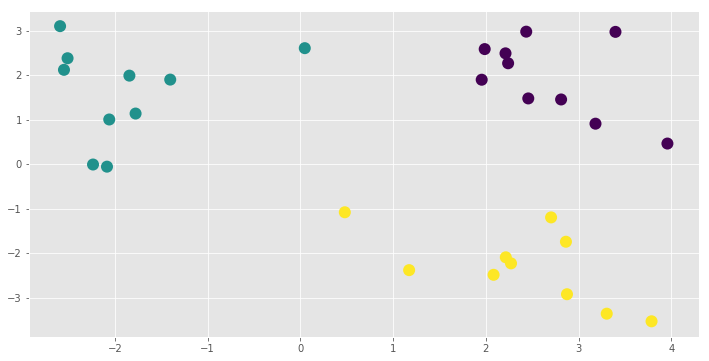

In [15]:
X = np.vstack([np.random.randn(10,2) + [2,2],
               np.random.randn(10,2) + [-2,2],
               np.random.randn(10,2) + [2,-2]])
Y = np.repeat(np.eye(3), 10, 0)

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)

In [16]:
m = LinearMulticlass(X, Y)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
LinearMulticlass/W,Parameter,None,(none),True,"(2, 3)",True,"[[0.971642933943, -0.770643873676, -2.08227665..."
LinearMulticlass/b,Parameter,None,(none),True,"(3,)",True,"[-1.4084119472, 0.419704363706, 0.389403623415]"


In [18]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000014
  Number of iterations: 23
  Number of functions evaluations: 25


,class,prior,transform,trainable,shape,fixed_shape,value
LinearMulticlass/W,Parameter,None,(none),True,"(2, 3)",True,"[[5.76899016491, -8.33505082164, 0.68478306236..."
LinearMulticlass/b,Parameter,None,(none),True,"(3,)",True,"[-7.57177883945, 1.80707568784, 5.16539919154]"


In [20]:
xx, yy = np.mgrid[-4:4:200j, -4:4:200j]
X_test = np.vstack([xx.flatten(), yy.flatten()]).T
f_test = np.dot(X_test, m.W.read_value()) + m.b.read_value()
p_test = np.exp(f_test)
p_test /= p_test.sum(1)[:,None]

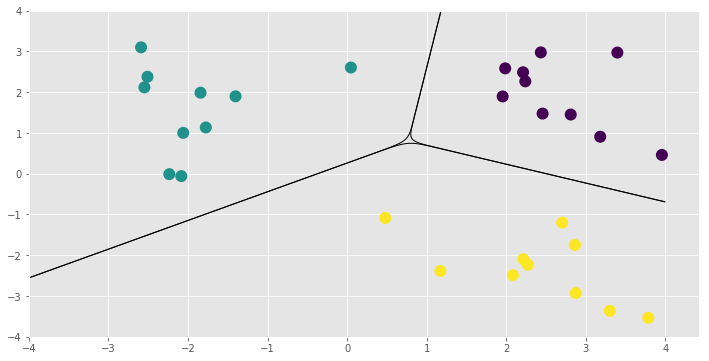

In [21]:
for i in range(3):
    plt.contour(xx, yy, p_test[:,i].reshape(200,200), [0.5], colors='k', linewidths=1)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)

# GPR Experiment: 
https://github.com/GPflow/GPflow/blob/master/doc/source/notebooks/regression.ipynb

In [23]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

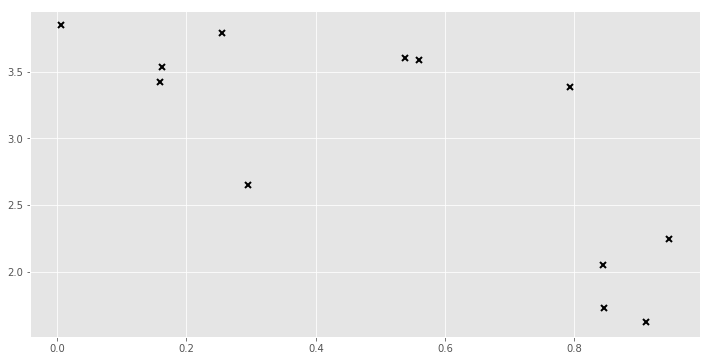

In [24]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

In [25]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


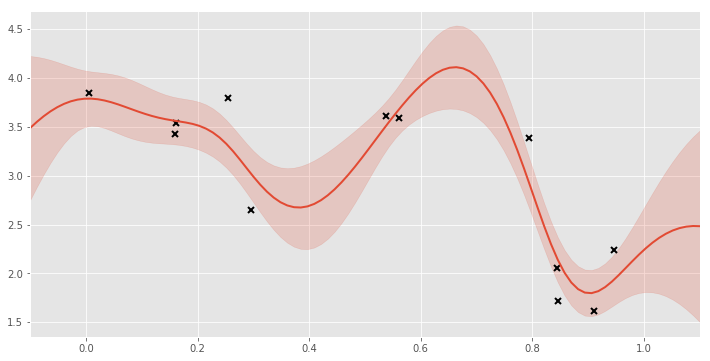

In [26]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)
    
plot(m)

In [27]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [28]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[1.0]]
GPR/mean_function/b,Parameter,None,(none),True,(),True,0.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.975101
  Number of iterations: 24
  Number of functions evaluations: 27


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[-1.75306404855]]
GPR/mean_function/b,Parameter,None,(none),True,(),True,3.9149847429035978
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.26734277823240393
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.021199118323860518
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.02941439914598157


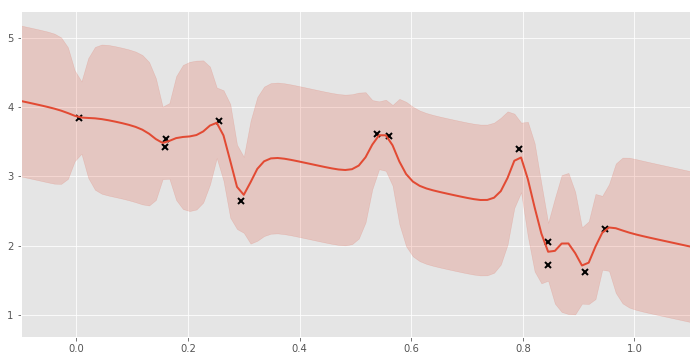

In [29]:
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m.as_pandas_table()

# With pollution data

In [64]:
#Needs to be float
X_datf = X_dat.astype(np.float64)

In [69]:
#Plot utility
def plot_gp(m, X_dat, Y_dat):
    minval = np.min(X_dat)
    maxval = np.max(X_dat)
    xx = np.linspace(0.9*minval, 1.1*maxval, 1000).reshape(1000, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X_dat, Y_dat, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(0.9*minval, 1.1*maxval)
    plt.show()

In [66]:
k = gpflow.kernels.RBF(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X_datf, Y_dat, k, meanf)
m.likelihood.variance = 0.01

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [67]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[1.0]]
GPR/mean_function/b,Parameter,None,(none),True,(),True,0.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [68]:
gpflow.train.ScipyOptimizer().minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 287.951055
  Number of iterations: 31
  Number of functions evaluations: 35


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[0.00966374443812]]
GPR/mean_function/b,Parameter,None,(none),True,(),True,13.044509932168541
GPR/kern/variance,Parameter,None,+ve,True,(),True,51.267020170274385
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.2999999999999999
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.020286640712990276


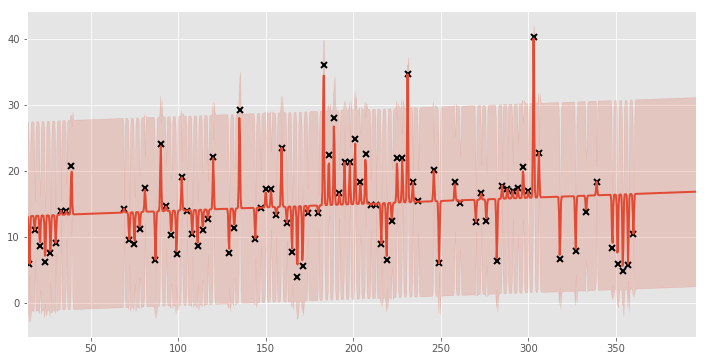

In [70]:
plot_gp(m, X_datf, Y_dat)

# Add priors, use MCMC

In [71]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(np.mean(Y_dat), 10.)
m.compile()
m.as_pandas_table()

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,"N([ 0.],[ 10.])",(none),True,"(1, 1)",True,[[0.00966374443812]]
GPR/mean_function/b,Parameter,"N([ 14.83411765],[ 10.])",(none),True,(),True,13.044509932168541
GPR/kern/variance,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,51.267020170274385
GPR/kern/lengthscales,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,0.2999999999999999
GPR/likelihood/variance,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,0.020286640712990276


In [72]:
sampler = gpf.train.HMC()
samples = sampler.sample(m, num_samples=1000, epsilon=0.05, lmin=10, lmax=20, logprobs=False)

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


Text(0,0.5,'parameter value')

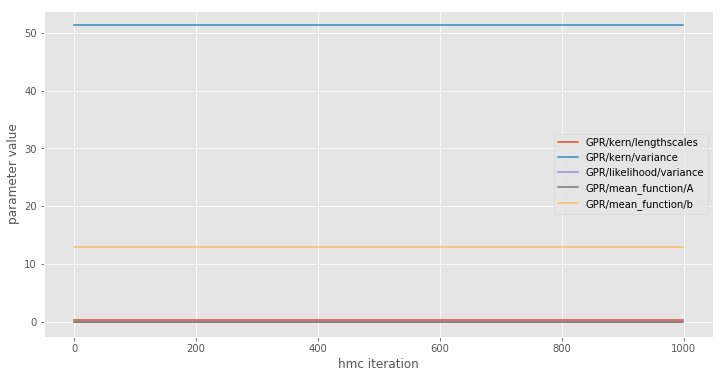

In [73]:
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

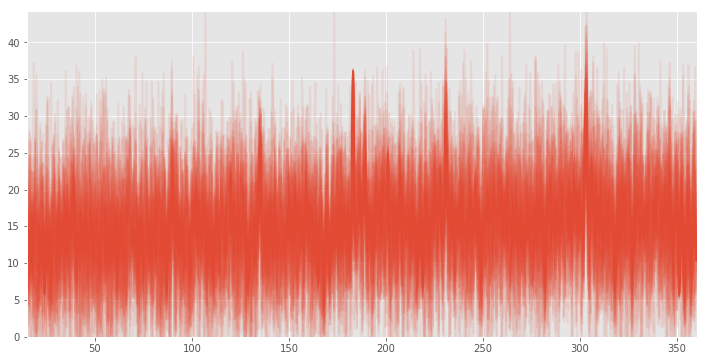

In [74]:
#plot the function posterior
xx = np.linspace(np.min(X_datf), np.max(X_datf), 500)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    m.assign(s)
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)
    
plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, np.max(Y_dat*1.1))

# Sparse approximation -- no prior 

In [81]:
m_sprs = gpf.models.SVGP(
    X_datf, Y_dat, kern=gpflow.kernels.RBF(1),
    likelihood=gpf.likelihoods.Gaussian(1),
    Z=X_datf[::5].copy(), num_latent=1, whiten=True, q_diag=True)

#Fix the sparse points 
m_sprs.feature.trainable = False

In [82]:
m_sprs.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),False,"(17, 1)",True,"[[15.0], [30.0], [72.0], [90.0], [105.0], [120..."
SVGP/q_mu,Parameter,None,(none),True,"(17, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(17, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [83]:
opt_sprs = gpf.train.ScipyOptimizer()
opt_sprs.minimize(m_sprs)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 291.707131
  Number of iterations: 188
  Number of functions evaluations: 218


In [84]:
m_sprs.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,87.31991580503977
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,274.2364198235001
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,48.184503606313434
SVGP/feature/Z,Parameter,None,(none),False,"(17, 1)",True,"[[15.0], [30.0], [72.0], [90.0], [105.0], [120..."
SVGP/q_mu,Parameter,None,(none),True,"(17, 1)",True,"[[1.06718767397], [1.58703294512], [0.34701021..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(17, 1)",True,"[[0.0987793810097], [0.16441802688], [0.268451..."


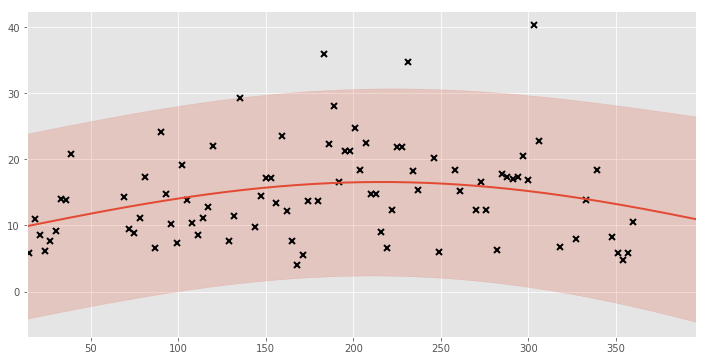

In [85]:
plot_gp(m_sprs, X_datf, Y_dat)

In [87]:
mean_sp, var_sp = m_sprs.predict_y(np.linspace(np.min(X_datf), np.max(X_datf), 30).reshape(-1,1))

In [88]:
print(mean_sp)

[[  9.97234902]
 [ 10.60475494]
 [ 11.22564349]
 [ 11.83089436]
 [ 12.4163777 ]
 [ 12.97799534]
 [ 13.51172288]
 [ 14.01365199]
 [ 14.48003248]
 [ 14.9073134 ]
 [ 15.2921828 ]
 [ 15.63160527]
 [ 15.92285698]
 [ 16.16355758]
 [ 16.35169839]
 [ 16.48566663]
 [ 16.56426516]
 [ 16.58672748]
 [ 16.55272771]
 [ 16.46238548]
 [ 16.3162655 ]
 [ 16.11537194]
 [ 15.86113758]
 [ 15.55540801]
 [ 15.200421  ]
 [ 14.79878142]
 [ 14.35343204]
 [ 13.86762068]
 [ 13.34486421]
 [ 12.7889098 ]]


In [89]:
print(var_sp)

[[ 49.03651697]
 [ 49.03935346]
 [ 49.04784571]
 [ 49.06204206]
 [ 49.08208804]
 [ 49.10822272]
 [ 49.14078468]
 [ 49.18022695]
 [ 49.22714045]
 [ 49.28228546]
 [ 49.34663078]
 [ 49.4214    ]
 [ 49.50812414]
 [ 49.60869917]
 [ 49.72544669]
 [ 49.86117509]
 [ 50.01923781]
 [ 50.20358499]
 [ 50.41880382]
 [ 50.67014308]
 [ 50.9635172 ]
 [ 51.30548542]
 [ 51.70320246]
 [ 52.16433816]
 [ 52.69696475]
 [ 53.30941201]
 [ 54.0100923 ]
 [ 54.80729916]
 [ 55.70898491]
 [ 56.72252392]]


# Look at space domain data 

In [91]:
print(dat.shape)
dat.head()

(151609, 5)


,site,MonitorData,day,x,y
0,0,5.9,15,3.767606e+06,739558.671618
1,0,11.0,18,3.767606e+06,739558.671618
2,0,8.6,21,3.767606e+06,739558.671618
3,0,6.2,24,3.767606e+06,739558.671618
4,0,7.6,27,3.767606e+06,739558.671618


In [94]:
# Consider all sites for one day: 
dat_d0 = dat[dat.day == 15]
nsites_total = len(dat.site.unique())
nsites_d0 = len(dat_d0.site.unique())
print("fraction of sites on this day: ", nsites_d0 / nsites_total)

fraction of sites on this day:  0.6338842975206611


In [100]:
#Create data 
X_space = dat_d0.loc[:, ['x', 'y']].values
Y_space = dat_d0.MonitorData.values.reshape(-1, 1)

In [152]:
#Figure out how sparse I want the inducing points to be 
print(X_space[::5].shape)

(154, 2)


In [153]:
#Generate new sparse model: 
m_space = gpf.models.SVGP(
    X_space, Y_space, kern=gpflow.kernels.RBF(2),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_space[::5].copy(), whiten=True, q_diag=True)

In [172]:
#gen not sparse model: 
k_space = gpf.kernels.RBF(input_dim=2)
meanf_space = gpf.mean_functions.Linear(np.ones((2,1)), 0.0)
m_space = gpf.models.GPR(X_space, Y_space, k_space, meanf_space)
m_space.likelihood.variance = 0.01

/anaconda3/envs/python3/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [182]:
#Use VGP
m_space = gpf.models.VGP(
    X_space, Y_space, kern=gpflow.kernels.RBF(2),
    likelihood=gpf.likelihoods.Gaussian())

In [183]:
m_space.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
VGP/q_mu,Parameter,None,(none),True,"(767, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 767, 767)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [184]:
opt_space = gpf.train.ScipyOptimizer()
opt_space.minimize(m_space)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3013.757932
  Number of iterations: 23
  Number of functions evaluations: 24


In [185]:
m_space.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,True,(),True,60.2791170867639
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/likelihood/variance,Parameter,None,+ve,True,(),True,91.23568281608885
VGP/q_mu,Parameter,None,(none),True,"(767, 1)",True,"[[0.302329402447], [0.245962903686], [0.302329..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 767, 767)",True,"[[[0.775987676873, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


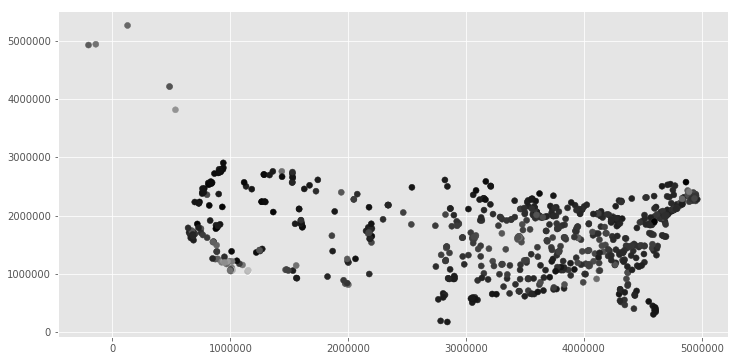

In [186]:
#Show scatter of original points: 
plt.scatter(X_space[:,0], X_space[:,1], c=Y_space[:,0])
plt.show()

In [142]:
#Gen interp (prediction) points
min_lon = 500000
max_lon = 5000000
min_lat = 0
max_lat = 3000000
nlon = 60 #longitudinal points 
nlat = int(nlon * (max_lat - min_lat) / (max_lon - min_lon))
X_preds = np.stack(np.meshgrid(np.linspace(min_lon, max_lon, nlon), np.linspace(min_lat, max_lat, nlat)), -1).reshape(-1, 2)

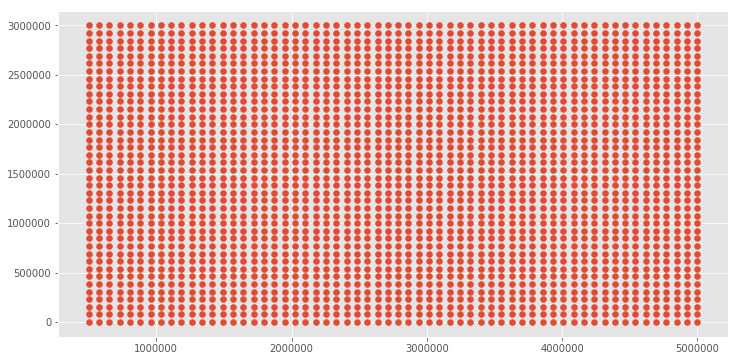

In [143]:
plt.scatter(X_preds[:,0], X_preds[:,1])
plt.show()

In [187]:
Y_preds_mean, Y_preds_var = m_space.predict_y(X_preds)

In [180]:
print(np.min(Y_preds_mean))

0.747627377168


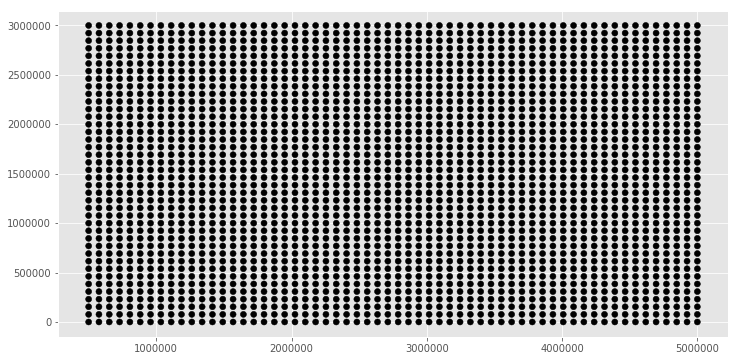

In [188]:
plt.scatter(X_preds[:,0], X_preds[:,1], c=Y_preds_mean[:,0])
plt.show()

In [209]:
#give a go with sklearn GP: 
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

import scipy.stats as st

In [206]:
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_space, Y_space)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=10,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [207]:
print("Learned kernel", gp.kernel_)

Learned kernel RBF(length_scale=4.34e+03)


In [208]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_preds, return_std=True)

In [210]:
posterior_nums = 3
posteriors = st.multivariate_normal.rvs(mean=y_pred, cov=sigma,
                                        size=posterior_nums)

ValueError: Array 'mean' must be a vector of length 2400.

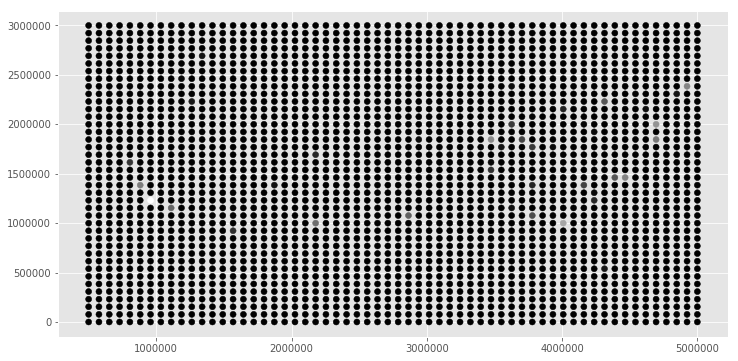

In [211]:
plt.scatter(X_preds[:,0], X_preds[:,1], c=y_pred[:,0])
plt.show()